# Estimating the size of the interactome


Interactome size is (assay sensitivity)^-1 * (sampling sensitivity(n screens))^-1 * (space coverage)^-1


## Principles 


Challenge: there is no random sample of real interactions, use literature
- Take the well-sampled subspace of the dense zone, which could reduce the bias of the PPIs from the detection methods but has danger of biasing through the subset of proteins and of the interaction density being different from the whole space

In [1]:
import os

import numpy as np
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt

from utils import (load_nw_lit_bm_17,
                   load_space_iii,
                   load_protein_coding_genome,
                   load_nw_hi_iii,
                   load_number_publications_per_gene)


%matplotlib inline
if not os.path.exists('../figures/interactome_size'):
    os.makedirs('../figures/interactome_size')

In [2]:
HURI_COLOR = (155 / 255, 97 / 255, 153 / 255)
LIT_COLOR = (60 / 255, 134 / 255, 184 / 255)
comma_fmt = mpl.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))
mpl.rcParams['pdf.fonttype'] = 42  # TrueType fonts for ease of editing in illustrator

In [3]:
lit_bm = load_nw_lit_bm_17()
space_iii = load_space_iii()
pcg = load_protein_coding_genome()
lit_bm = lit_bm.loc[lit_bm['ensembl_gene_id_a'].isin(space_iii) & 
                    lit_bm['ensembl_gene_id_b'].isin(space_iii), :]
hi_iii = load_nw_hi_iii()
hi_iii['pair'] = hi_iii['ensembl_gene_id_a'] + '_' + hi_iii['ensembl_gene_id_b']
lit_bm['pair'] = lit_bm['ensembl_gene_id_a'] + '_' + lit_bm['ensembl_gene_id_b']
hi_iii = hi_iii.loc[hi_iii['ensembl_gene_id_a'] != hi_iii['ensembl_gene_id_b'], :]
lit_bm = lit_bm.loc[lit_bm['ensembl_gene_id_a'] != lit_bm['ensembl_gene_id_b'], :]

In [4]:
hi_iii.shape

(52088, 15)

In [5]:
completeness = (len(space_iii)**2 / len(pcg)**2)
n_lit_in_hi = hi_iii['pair'].isin(lit_bm['pair']).sum()
n_lit_bm = lit_bm.shape[0]
sensitivity = n_lit_in_hi / n_lit_bm
hi_iii.shape[0] * (0.8) * (1 / sensitivity * (1 / completeness))

993655.9038431086

In [6]:
sensitivity

0.054351751534850126

In [7]:
completeness

0.7715749295987777

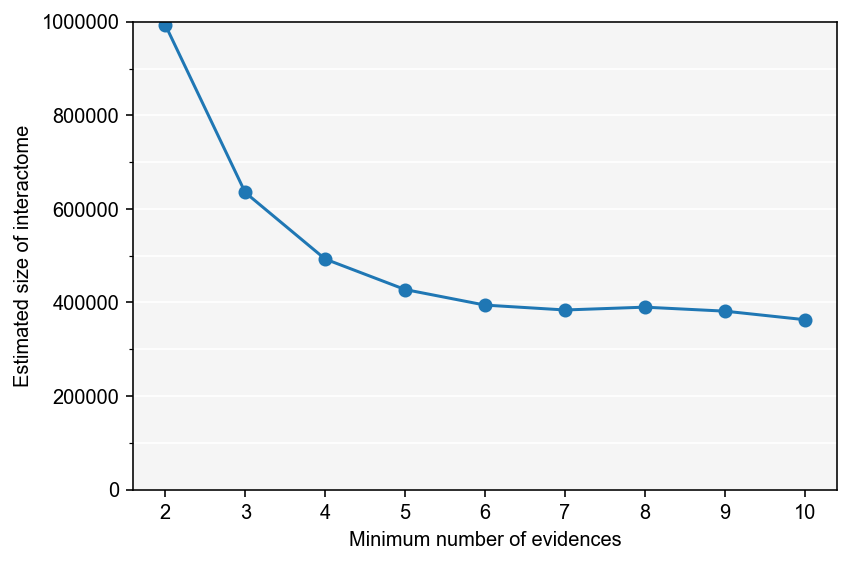

In [8]:
sizes = []
for min_n_pub in range(2, 11):
    n_in_hi = hi_iii['pair'].isin(lit_bm.loc[lit_bm['n_evidences'] >= min_n_pub, 'pair']).sum()
    n_lit = (lit_bm['n_evidences'] >= min_n_pub).sum()
    sensitivity = n_in_hi / n_lit
    sizes.append(hi_iii.shape[0] * (0.8) * (1 / sensitivity * (1 / completeness)))
fig, ax = plt.subplots(1, 1)
ax.set_facecolor('0.96')
ax.grid(color='white', axis='y', which='both', zorder=5)
ax.plot(list(range(2, 11)), sizes,
         'o-')
plt.ylim(0, 1000000)
ax.set_yticks(range(100000, 999999, 200000), minor=True)
plt.xlabel('Minimum number of evidences')
plt.ylabel('Estimated size of interactome')
plt.tight_layout()
plt.savefig('../figures/interactome_size/interactome_estimate_by_n_evidence.pdf')

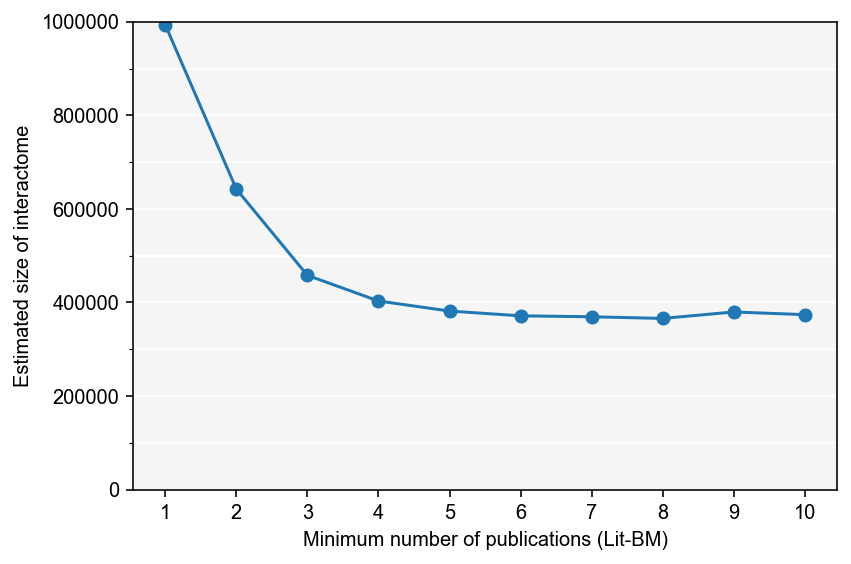

In [9]:
sizes = []
for min_n_pub in range(1, 11):
    n_in_hi = hi_iii['pair'].isin(lit_bm.loc[lit_bm['n_publications'] >= min_n_pub, 'pair']).sum()
    n_lit = (lit_bm['n_publications'] >= min_n_pub).sum()
    sensitivity = n_in_hi / n_lit
    sizes.append(hi_iii.shape[0] * (0.8) * (1 / sensitivity) * (1 / completeness))
fig, ax = plt.subplots(1, 1)
ax.set_facecolor('0.96')
ax.grid(color='white', axis='y', which='both', zorder=5)
plt.plot(list(range(1, 11)), sizes,
         'o-')
plt.ylim(0, 1000000)
ax.set_yticks(range(100000, 999999, 200000), minor=True)
plt.xticks(list(range(1, 11)))
plt.xlabel('Minimum number of publications (Lit-BM)')
plt.ylabel('Estimated size of interactome')
plt.tight_layout()
plt.savefig('../figures/interactome_size/interactome_estimate_by_n_pub.pdf')

In [10]:
hi_iii.head()

,ensembl_gene_id_a,ensembl_gene_id_b,in_screen_1,in_screen_2,in_screen_3,in_screen_4,in_screen_5,in_screen_6,in_screen_7,in_screen_8,in_screen_9,in_assay_v1,in_assay_v2,in_assay_v3,pair
0,ENSG00000000005,ENSG00000061656,False,False,False,False,False,True,False,False,False,False,True,False,ENSG00000000005_ENSG00000061656
1,ENSG00000000005,ENSG00000099968,False,False,False,False,True,False,False,False,False,False,True,False,ENSG00000000005_ENSG00000099968
2,ENSG00000000005,ENSG00000104765,False,False,True,False,False,False,False,False,False,True,False,False,ENSG00000000005_ENSG00000104765
3,ENSG00000000005,ENSG00000105383,False,False,False,False,False,False,False,False,True,False,False,True,ENSG00000000005_ENSG00000105383
4,ENSG00000000005,ENSG00000114455,False,False,False,False,False,False,False,False,True,False,False,True,ENSG00000000005_ENSG00000114455


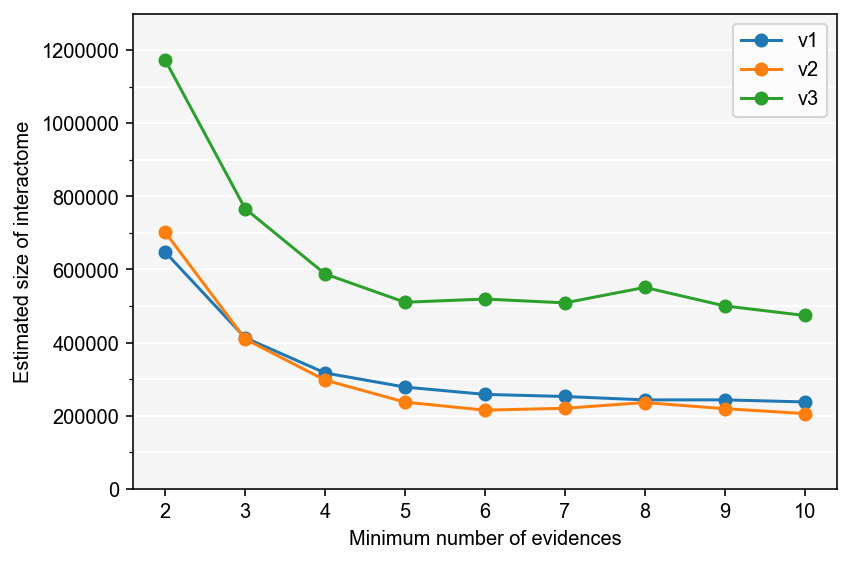

In [11]:
sizes_v1 = []
sizes_v2 = []
sizes_v3 = []
for min_n_pub in range(2, 11):
    n_in_v1 = hi_iii.loc[hi_iii['in_assay_v1'], 'pair'].isin(lit_bm.loc[lit_bm['n_evidences'] >= min_n_pub, 'pair']).sum()
    n_in_v2 = hi_iii.loc[hi_iii['in_assay_v2'], 'pair'].isin(lit_bm.loc[lit_bm['n_evidences'] >= min_n_pub, 'pair']).sum()
    n_in_v3 = hi_iii.loc[hi_iii['in_assay_v3'], 'pair'].isin(lit_bm.loc[lit_bm['n_evidences'] >= min_n_pub, 'pair']).sum()
    n_lit = (lit_bm['n_evidences'] >= min_n_pub).sum()
    sizes_v1.append(hi_iii['in_assay_v1'].sum() * (0.8) * (1 / (n_in_v1 / n_lit) * (1 / completeness)))
    sizes_v2.append(hi_iii['in_assay_v2'].sum() * (0.8) * (1 / (n_in_v2 / n_lit) * (1 / completeness)))
    sizes_v3.append(hi_iii['in_assay_v3'].sum() * (0.8) * (1 / (n_in_v3 / n_lit) * (1 / completeness)))
fig, ax = plt.subplots(1, 1)
ax.set_facecolor('0.96')
ax.grid(color='white', axis='y', which='both', zorder=5)
ax.plot(list(range(2, 11)), sizes_v1,
         'o-', label='v1')
ax.plot(list(range(2, 11)), sizes_v2,
         'o-', label='v2')
ax.plot(list(range(2, 11)), sizes_v3,
         'o-', label='v3')
ax.legend()
ymax = 1300000
plt.ylim(0, ymax)
ax.set_yticks(range(100000, ymax, 200000), minor=True)
plt.xlabel('Minimum number of evidences')
plt.ylabel('Estimated size of interactome')
plt.tight_layout()
plt.savefig('../figures/interactome_size/interactome_estimate_split_assay_versions_by_n_evidence.pdf')

In [12]:
n_pub = load_number_publications_per_gene()
n_pub = n_pub[n_pub.index.isin(space_iii)]
for nw in [lit_bm, hi_iii]:
    nw['n_pubs_a'] = nw['ensembl_gene_id_a'].map(n_pub).fillna(0)
    nw['n_pubs_b'] = nw['ensembl_gene_id_b'].map(n_pub).fillna(0)
    nw['n_pubs_min'] = nw[['n_pubs_a', 'n_pubs_b']].min(axis=1)

In [13]:
# n values
for n_ppi_evid in [2, 3, 4, 6]:
    print(n_ppi_evid,
          (lit_bm.loc[lit_bm['n_evidences'] >= n_ppi_evid, 'n_pubs_min'] >= 250).sum())

2 1215
3 750
4 527
6 337


In [14]:
hi_iii.head()

,ensembl_gene_id_a,ensembl_gene_id_b,in_screen_1,in_screen_2,in_screen_3,in_screen_4,in_screen_5,in_screen_6,in_screen_7,in_screen_8,in_screen_9,in_assay_v1,in_assay_v2,in_assay_v3,pair,n_pubs_a,n_pubs_b,n_pubs_min
0,ENSG00000000005,ENSG00000061656,False,False,False,False,False,True,False,False,False,False,True,False,ENSG00000000005_ENSG00000061656,24,11,11
1,ENSG00000000005,ENSG00000099968,False,False,False,False,True,False,False,False,False,False,True,False,ENSG00000000005_ENSG00000099968,24,38,24
2,ENSG00000000005,ENSG00000104765,False,False,True,False,False,False,False,False,False,True,False,False,ENSG00000000005_ENSG00000104765,24,51,24
3,ENSG00000000005,ENSG00000105383,False,False,False,False,False,False,False,False,True,False,False,True,ENSG00000000005_ENSG00000105383,24,92,24
4,ENSG00000000005,ENSG00000114455,False,False,False,False,False,False,False,False,True,False,False,True,ENSG00000000005_ENSG00000114455,24,16,16


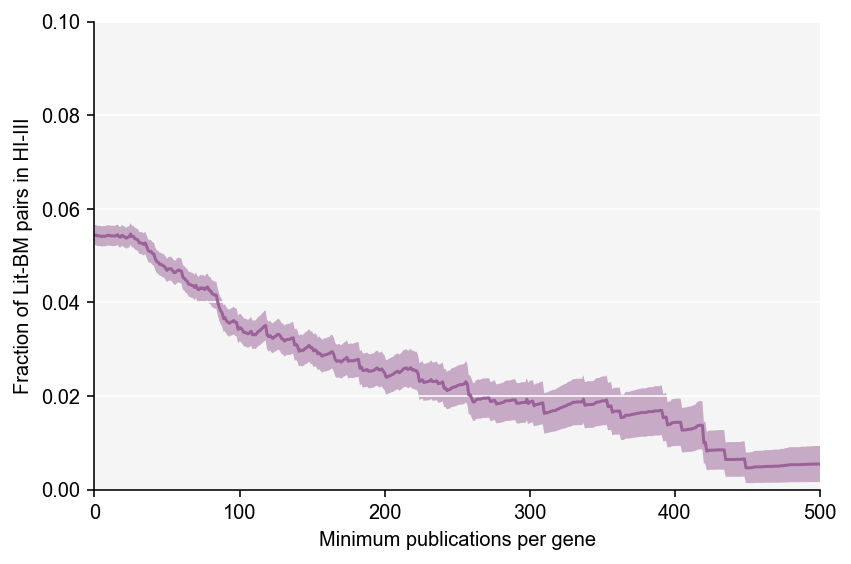

In [15]:
n_pubs = list(range(0, 701))
errs = []
fs = []
for n in n_pubs:
    a = set(hi_iii.loc[(hi_iii['n_pubs_min'] >= n), 'pair'].values)
    b = set(lit_bm.loc[(lit_bm['n_pubs_min'] >= n), 'pair'].values)
    f = len(a.intersection(b)) / len(b)
    fs.append(f)
    # Using the standard error of proportion ignores the variability from
    # the number of literature pairs. Should be OK, since the number of HI-III
    # pairs at higher cutoffs is much smaller
    errs.append(np.sqrt((f * (1. - f)) / len(b)))

    
fig, ax = plt.subplots(1, 1)
#fig.set_size_inches(2.5, 1.8)
ax.plot(n_pubs, fs, color=HURI_COLOR)
ax.fill_between(n_pubs, 
                [f - err for f, err in zip(fs, errs)], 
                [f + err for f, err in zip(fs, errs)],
                alpha=0.5, color=HURI_COLOR, linewidth=0)
ax.set_facecolor('0.96')
ax.grid(color='white', axis='y', which='both', zorder=5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0., 0.1)
ax.set_xlim(0., 500)
ax.set_xlabel('Minimum publications per gene')
ax.set_ylabel('Fraction of Lit-BM pairs in HI-III')
plt.tight_layout()
plt.savefig('../figures/interactome_size/lit_recovery_by_n_publications.pdf')

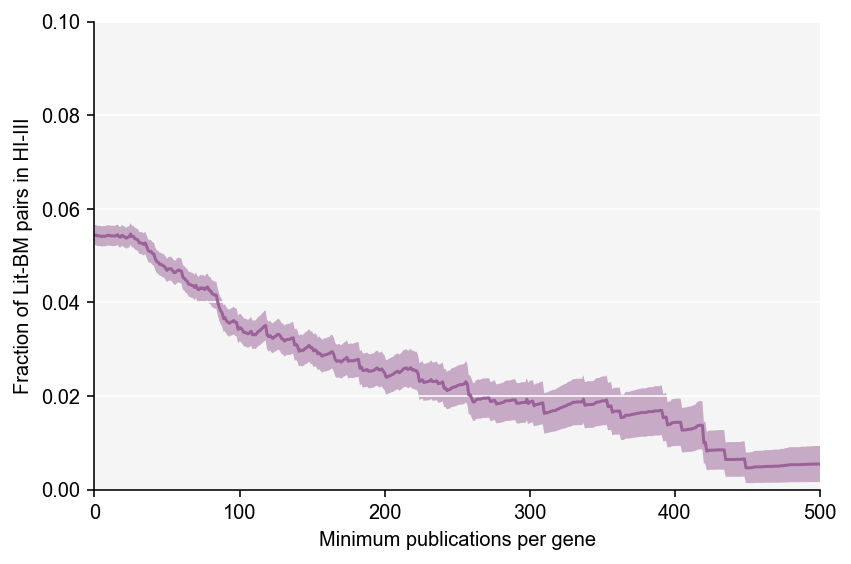

In [16]:
# Do 
n_pubs = list(range(0, 701))
errs = []
fs = []
for n in n_pubs:
    a = set(hi_iii.loc[(hi_iii['n_pubs_min'] >= n), 'pair'].values)
    b = set(lit_bm.loc[(lit_bm['n_pubs_min'] >= n), 'pair'].values)
    f = len(a.intersection(b)) / len(b)
    fs.append(f)
    # Using the standard error of proportion ignores the variability from
    # the number of literature pairs. Should be OK, since the number of HI-III
    # pairs at higher cutoffs is much smaller
    errs.append(np.sqrt((f * (1. - f)) / len(b)))

    
fig, ax = plt.subplots(1, 1)
#fig.set_size_inches(2.5, 1.8)
ax.plot(n_pubs, fs, color=HURI_COLOR)
ax.fill_between(n_pubs, 
                [f - err for f, err in zip(fs, errs)], 
                [f + err for f, err in zip(fs, errs)],
                alpha=0.5, color=HURI_COLOR, linewidth=0)
ax.set_facecolor('0.96')
ax.grid(color='white', axis='y', which='both', zorder=5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0., 0.1)
ax.set_xlim(0., 500)
ax.set_xlabel('Minimum publications per gene')
ax.set_ylabel('Fraction of Lit-BM pairs in HI-III')
plt.tight_layout()
plt.savefig('../figures/interactome_size/lit_recovery_by_n_publications.pdf')

In [17]:
def overlap(nw_a, nw_b, min_pub):
    a = set(nw_a.loc[nw_a['n_pubs_min'] >= min_pub, 'pair'].values)
    b = set(nw_b.loc[nw_b['n_pubs_min'] >= min_pub, 'pair'].values)
    return len(a), len(b), len(a.intersection(b))


overlap(hi_iii, lit_bm, 200)

(140, 1764, 44)

In [18]:
def overlap_with_ci(nw_a, nw_b, min_pub):
    return _overlap_with_ci(*overlap(nw_a, nw_b, min_pub))

def _overlap_with_ci(K, n, k):
    print('K, n, k = ', K, n, k)
    f = k / K
    N_hat = ((K+1)*(n+1))/(k+1) - 1
    N_low = (
                K + n - k - 0.5
                + (((K - k + 0.5) * (n - k + 0.5))
                  / (k + 0.5) )
                  * np.exp(-np.sqrt(1 / (k + 0.5) 
                                    + 1 / (K - k + 0.5) 
                                    + 1 / (n - k + 0.5) 
                                    + (k + 0.5) / ((n - k + 0.5) * (K - k + 0.5))))
    )
    N_high = (
                K + n - k - 0.5
                + (((K - k + 0.5) * (n - k + 0.5))
                  / (k + 0.5) )
                  * np.exp(np.sqrt(1 / (k + 0.5) 
                                    + 1 / (K - k + 0.5) 
                                    + 1 / (n - k + 0.5) 
                                    + (k + 0.5) / ((n - k + 0.5) * (K - k + 0.5))))
    )
    print('N-hat = ', N_hat)
    print(N_low, N_high)
    f_low = f / (N_high / N_hat)
    f_high = f / (N_low / N_hat)
    return f, f_low, f_high


def overlap_with_bayes_error(nw_a, nw_b, min_pub):
    return _overlap_with_bayes_error(*overlap(nw_a, nw_b, min_pub))


def _overlap_with_bayes_error(K, n, k):
    f = k / K
    f_low, f_high = stats.beta.interval(0.6827, k + 1, (K - k) + 1)
    return f, f_low, f_high

overlap_with_ci(lit_bm, hi_iii, 200)  # ref: 2.5% +- 0.4%

K, n, k =  1764 140 44
N-hat =  5529.333333333333
4964.883257549416 6342.087249160486


(0.024943310657596373, 0.021746764691859596, 0.02777907795777884)

In [19]:
overlap_with_ci(lit_bm, hi_iii, 400) 

K, n, k =  557 18 8
N-hat =  1177.0
992.8958765692074 1647.0954735293126


(0.01436265709156194, 0.010263428968416477, 0.017025800787067818)

In [20]:
overlap_with_bayes_error(lit_bm, hi_iii, 400)

(0.01436265709156194, 0.01087293889239076, 0.02133147917997147)

In [21]:
overlap_with_ci(lit_bm, hi_iii, 0)

K, n, k =  11076 52088 602
N-hat =  956864.4278606966
920722.0529110153 996182.6727818587


(0.054351751534850126, 0.05220654710886495, 0.05648529593832529)

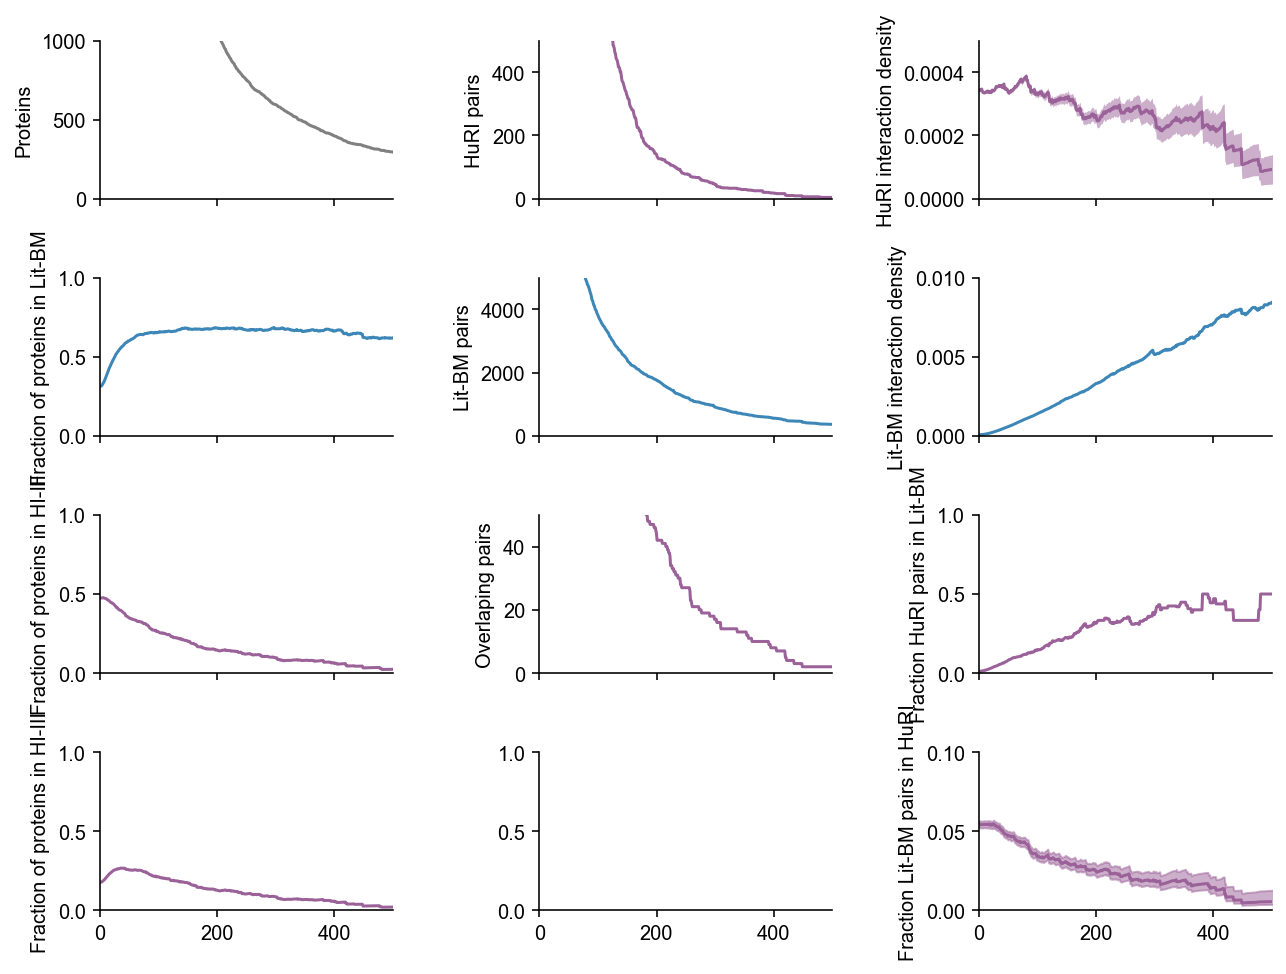

In [22]:
def proteins_in_nw(nw):
    return set(nw['ensembl_gene_id_a'].values).union(set(nw['ensembl_gene_id_b'].values))

def count_proteins_in_nw(nw):
    return len(proteins_in_nw(nw))

def count_proteins(nw, n):
    return count_proteins_in_nw(nw.loc[(nw['n_pubs_min'] >= n), :])

def fraction_proteins_in_overlap(n, nw_a, nw_b):
    return len(proteins_in_nw(nw_a.loc[nw_a['n_pubs_min'] >= n, :])
               .intersection(
                    proteins_in_nw(nw_b.loc[nw_b['n_pubs_min'] >= n, :]))) / (n_pub >= n).sum()

def panel_plot(lit_bm):
    n_pubs = list(range(0, 701))
    hi_density = []
    lit_density = []
    n_hi_pairs = []
    n_lit_pairs = []
    n_overlap_pairs = []
    errs = []
    for n in n_pubs:
        hi_pairs = set(hi_iii.loc[(hi_iii['n_pubs_min'] >= n), 'pair'].values)
        n_hi_pairs.append(len(hi_pairs))
        lit_pairs = set(lit_bm.loc[(lit_bm['n_pubs_min'] >= n), 'pair'].values)
        n_lit_pairs.append(len(lit_pairs))
        n_overlap_pairs.append(len(hi_pairs.intersection(lit_pairs)))
        n_proteins = (n_pub >= n).sum()
        dense_area = (n_proteins ** 2 - n_proteins) / 2
        hi_density.append(len(hi_pairs) / dense_area)
        lit_density.append(len(lit_pairs) / dense_area)
        errs.append(np.sqrt(len(hi_pairs)) / dense_area)



    n_rows = 4
    n_columns = 3
    fig, axes = plt.subplots(n_rows, n_columns, sharex=True)
    fig.set_size_inches(3.5 * n_columns, n_rows * 2)

    #### First column: number of proteins #####
    ax = axes[0, 0]
    ax.plot(n_pubs,
            [(n_pub >= n).sum() for n in n_pubs],
            color='grey')
    ax.set_ylim(0, 1000)
    ax.set_ylabel('Proteins')


    ax = axes[1, 0]
    ax.plot(n_pubs,
            [count_proteins(lit_bm, n) / (n_pub >= n).sum() for n in n_pubs],
            color=LIT_COLOR)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Fraction of proteins in Lit-BM')


    ax = axes[2, 0]
    ax.plot(n_pubs,
            [count_proteins(hi_iii, n) / (n_pub >= n).sum() for n in n_pubs],
            color=HURI_COLOR)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Fraction of proteins in HI-III')

    ax = axes[3, 0]
    ax.plot(n_pubs,
            [fraction_proteins_in_overlap(n, hi_iii, lit_bm) for n in n_pubs],
            color=HURI_COLOR)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Fraction of proteins in HI-III')

    #### Second column: number of pairs ######
    ax = axes[0, 1]
    ax.plot(n_pubs,
            n_hi_pairs,
            color=HURI_COLOR)
    ax.set_ylim(0, 500)
    ax.set_ylabel('HuRI pairs')

    ax = axes[1, 1]
    ax.plot(n_pubs,
            n_lit_pairs,
            color=LIT_COLOR)
    ax.set_ylim(0, 5000)
    ax.set_ylabel('Lit-BM pairs')


    ax = axes[2, 1]
    ax.plot(n_pubs,
            n_overlap_pairs,
            color=HURI_COLOR)
    ax.set_ylim(0, 50)
    ax.set_ylabel('Overlaping pairs')


    ### Third column: MISC ###
    ax = axes[0, 2]
    ax.plot(n_pubs,
            hi_density,
             color=HURI_COLOR)
    ax.fill_between(n_pubs, 
                    [f - err for f, err in zip(hi_density, errs)], 
                    [f + err for f, err in zip(hi_density, errs)],
                    alpha=0.5, color=HURI_COLOR, linewidth=0)
    ax.set_ylim(0, 0.0005)
    ax.set_ylabel('HuRI interaction density')

    ax = axes[1, 2]
    ax.plot(n_pubs,
            lit_density,
             color=LIT_COLOR)
    #ax.fill_between(n_pubs, 
    #                [f - err for f, err in zip(lit_density, errs)], 
    #                [f + err for f, err in zip(lit_density, errs)],
    #                alpha=0.5, color=HURI_COLOR, linewidth=0)
    ax.set_ylim(0, 0.01)
    ax.set_ylabel('Lit-BM interaction density')

    ax = axes[2, 2]
    ax.plot(n_pubs,
            [a / b for a, b in zip(n_overlap_pairs, n_hi_pairs)],
            color=HURI_COLOR)
    ax.set_ylim(0, 1.)
    ax.set_ylabel('Fraction HuRI pairs in Lit-BM')

    ax = axes[3, 2]
    ax.plot(n_pubs,
            [a / b for a, b in zip(n_overlap_pairs, n_lit_pairs)],
            color=HURI_COLOR)
    
    ax.fill_between(n_pubs,
                     [overlap_with_bayes_error(lit_bm, hi_iii, n)[1] for n in n_pubs],
                     [overlap_with_bayes_error(lit_bm, hi_iii, n)[2] for n in n_pubs],
                     color=HURI_COLOR,
                     alpha=0.5)
    
    ax.set_ylim(0, 0.1)
    ax.set_ylabel('Fraction Lit-BM pairs in HuRI')


    for ax in axes.flatten():
        ax.set_xlim(0, 500)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    
    
panel_plot(lit_bm)

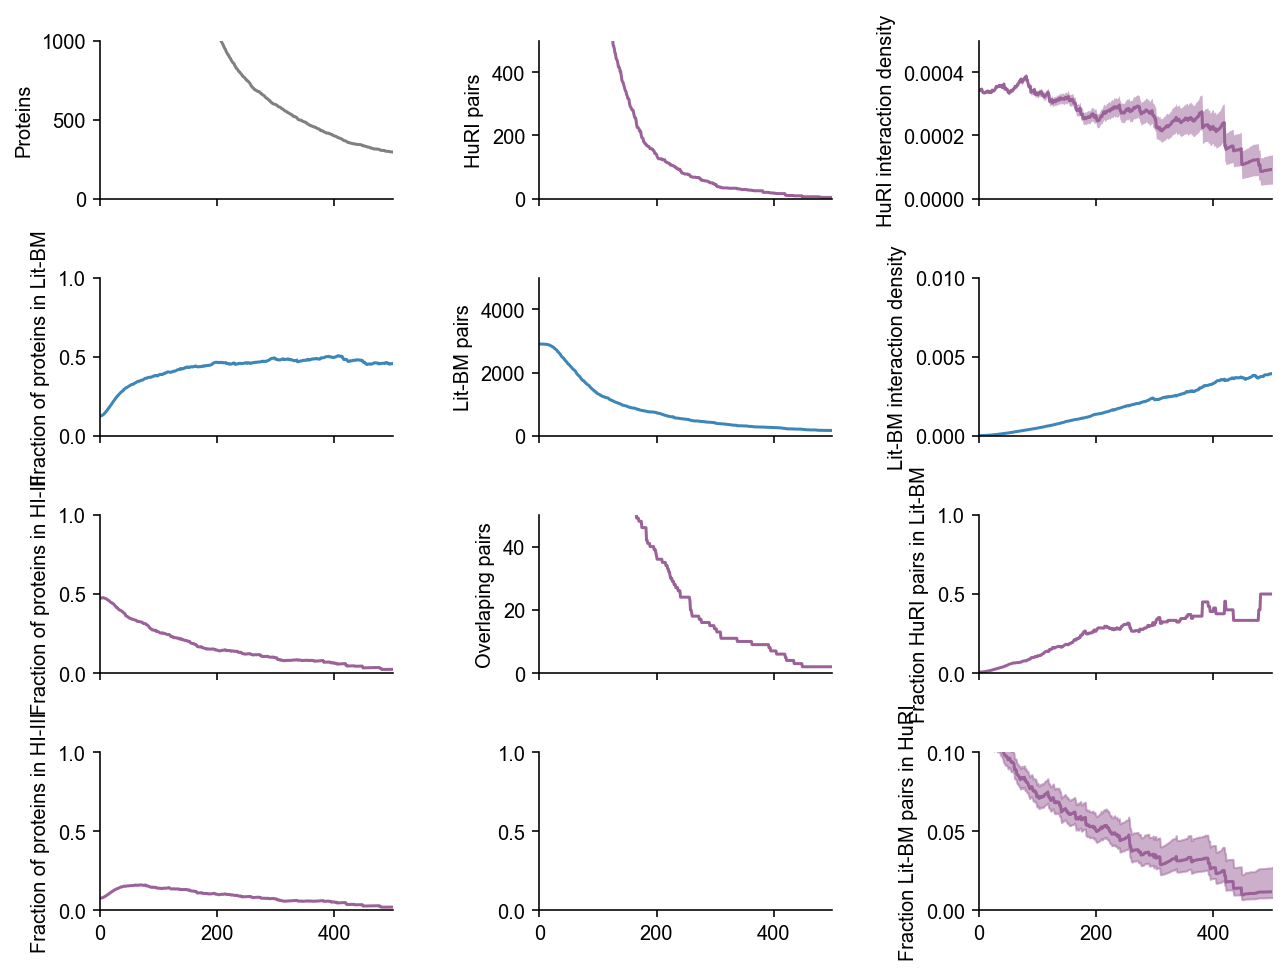

In [23]:
panel_plot(lit_bm.loc[lit_bm['n_evidences'] >= 4, :])

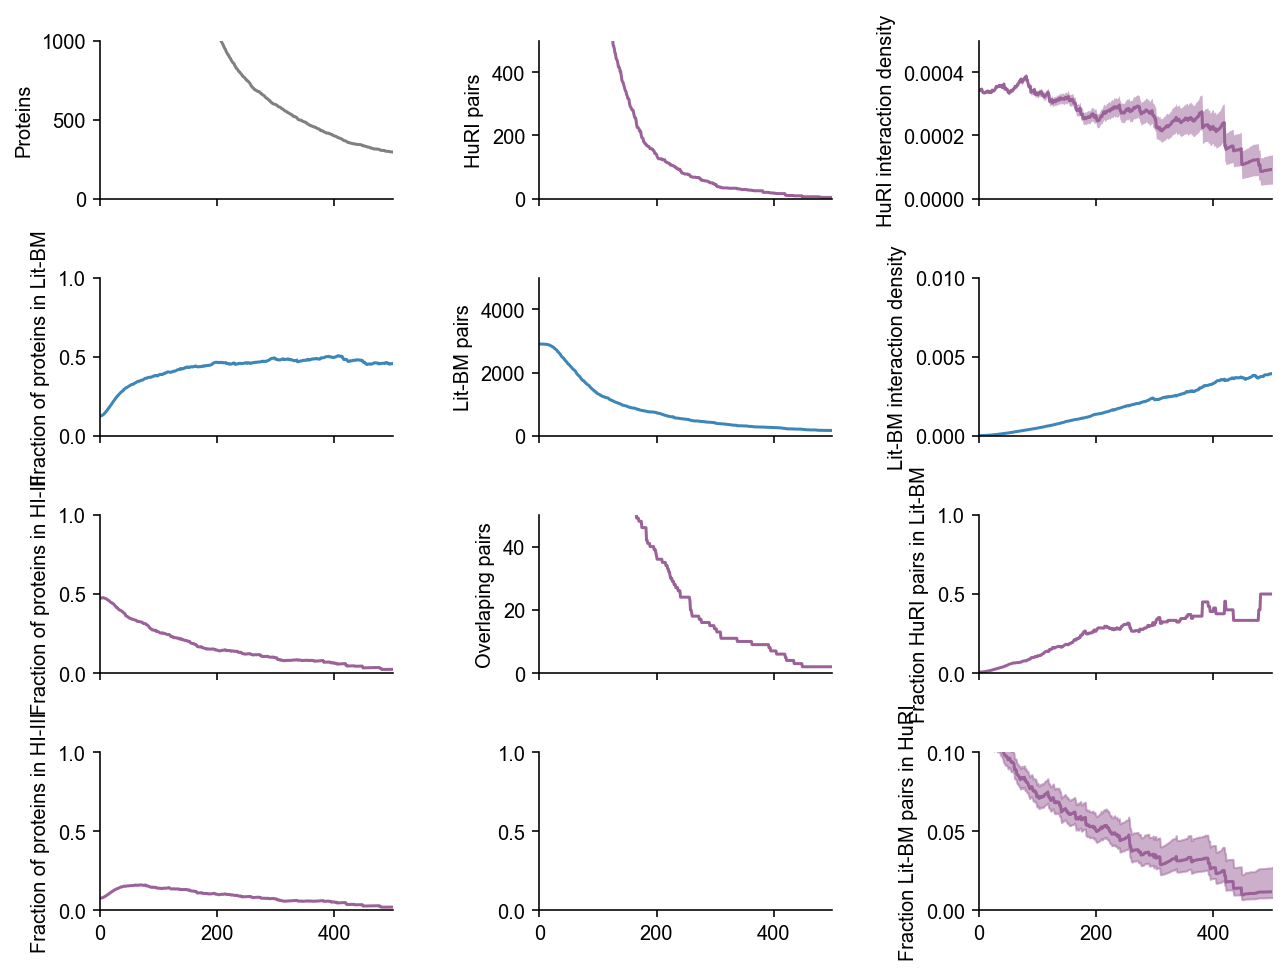

In [24]:
panel_plot(lit_bm.loc[lit_bm['n_evidences'] >= 4, :])

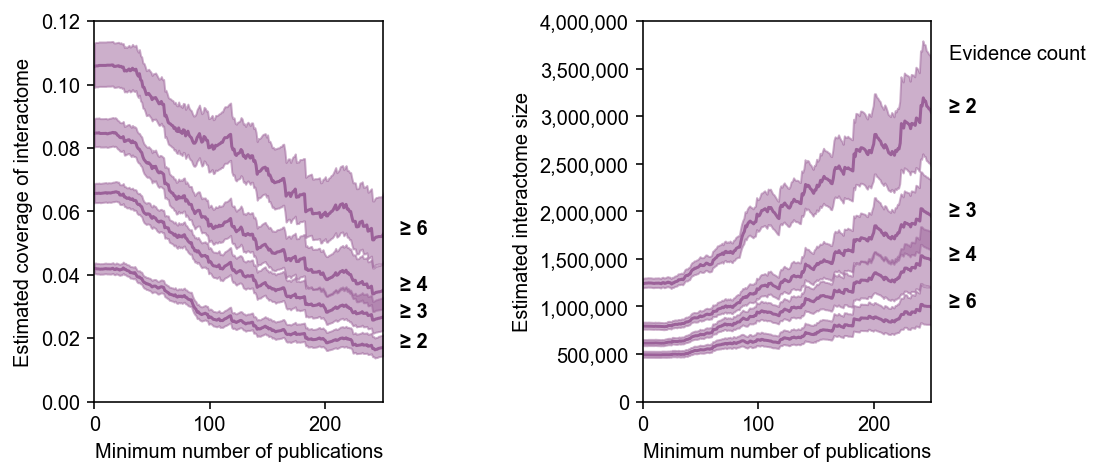

In [25]:
# Just fraction overlap and interactome size
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7.5, 3.5)
n_pubs = list(range(500))
space_completeness = (len(space_iii)**2 / len(pcg)**2)

def overlap_plot(hi_iii, lit_bm, ax):
    ax.plot(n_pubs,
            [overlap_with_bayes_error(lit_bm, hi_iii, n)[0] for n in n_pubs],
            color=HURI_COLOR)
    ax.fill_between(n_pubs,
                     [overlap_with_bayes_error(lit_bm, hi_iii, n)[1] for n in n_pubs],
                     [overlap_with_bayes_error(lit_bm, hi_iii, n)[2] for n in n_pubs],
                     color=HURI_COLOR,
                     alpha=0.5)
    
    
def coverage_plot(hi_iii, lit_bm, ax):
    space_completeness = (len(space_iii)**2 / len(pcg)**2)
    ax.plot(n_pubs,
            [space_completeness * overlap_with_bayes_error(lit_bm, hi_iii, n)[0] for n in n_pubs],
            color=HURI_COLOR)
    ax.fill_between(n_pubs,
                     [space_completeness * overlap_with_bayes_error(lit_bm, hi_iii, n)[1] for n in n_pubs],
                     [space_completeness * overlap_with_bayes_error(lit_bm, hi_iii, n)[2] for n in n_pubs],
                     color=HURI_COLOR,
                     alpha=0.5)

    
def estimate_interactome_size(hi_iii, lit_bm, min_n_pub):
    space_completeness = (len(space_iii)**2 / len(pcg)**2)
    precision = 1.
    lit_coverage = overlap_with_bayes_error(lit_bm, hi_iii, min_n_pub)[0]
    n_ppi = hi_iii.shape[0]
    return (n_ppi * precision) / (space_completeness * lit_coverage)
    
    
def interactome_size_plot(hi_iii, lit_bm, ax):
    space_completeness = (len(space_iii)**2 / len(pcg)**2) 
    lit_coverage = [overlap_with_bayes_error(lit_bm, hi_iii, n)[0] for n in n_pubs]
    lit_coverage_up = [overlap_with_bayes_error(lit_bm, hi_iii, n)[2] for n in n_pubs]
    lit_coverage_dn = [overlap_with_bayes_error(lit_bm, hi_iii, n)[1] for n in n_pubs]
    precision = 1.
    n_ppi = hi_iii.shape[0]
    size_estimates = [(n_ppi * precision) / (space_completeness * lc) for lc in lit_coverage]
    size_dn = [(n_ppi * precision) / (space_completeness * lc) for lc in lit_coverage_up]
    size_up = [(n_ppi * precision) / (space_completeness * lc) for lc in lit_coverage_dn]
    ax.plot(n_pubs,
            size_estimates,
            color=HURI_COLOR)
    ax.fill_between(n_pubs,
                    size_dn,
                    size_up,
                    color=HURI_COLOR,
                    alpha=0.5)

xmax = 250
ymax_interactome_size = 4000000
for n_evid in [2, 3, 4, 6]:
    coverage_plot(hi_iii, lit_bm.loc[lit_bm['n_evidences'] >= n_evid, :], axes[0])
    interactome_size_plot(hi_iii, lit_bm.loc[lit_bm['n_evidences'] >= n_evid, :], axes[1])
    axes[0].text(s='≥ ' + str(n_evid), 
                 x=xmax * 1.06,
                 y=overlap_with_bayes_error(lit_bm.loc[lit_bm['n_evidences'] >= n_evid, :],
                                            hi_iii, 
                                            xmax)[0] * space_completeness,
                 fontweight='bold')
    axes[1].text(s='≥ ' + str(n_evid), 
                 x=xmax * 1.06,
                 y=estimate_interactome_size(hi_iii, 
                                             lit_bm.loc[lit_bm['n_evidences'] >= n_evid, :],
                                             xmax),
                 fontweight='bold')
axes[1].text(s='Evidence count', 
             x=xmax * 1.06,
             y=ymax_interactome_size * 0.9,
             fontweight='regular')
axes[0].set_ylim(0, 0.12)
axes[0].set_xlim(0, xmax)
axes[0].set_xlabel('Minimum number of publications')
axes[0].set_ylabel('Estimated coverage of interactome')


axes[1].yaxis.set_major_formatter(comma_fmt)
axes[1].set_xlim(0, xmax)
axes[1].set_ylim(0, ymax_interactome_size)
axes[1].set_xlabel('Minimum number of publications')
axes[1].set_ylabel('Estimated interactome size')



plt.subplots_adjust(wspace=0.9)
plt.savefig('../figures/interactome_size/coverage_and_size.pdf',
            bbox_inches='tight')

In [26]:
def stumpf_mn(n_nodes, n_edges, total_nodes=len(pcg)):
    return n_edges * ((total_nodes * (total_nodes - 1)) / (n_nodes * (n_nodes - 1)))


stumpf_mn(1527, 2529)

426238.8114309403

In [27]:
(stumpf_mn(1665, 3083, 24100),
 stumpf_mn(1527, 2529, 24100),
 stumpf_mn(1085, 1346, 24100))

(646281.9537205475, 630334.8555618783, 664663.9187511691)

In [29]:
stumpf_mn(count_proteins_in_nw(hi_iii), hi_iii.shape[0], 24100)

444742.9779773546

In [30]:
stumpf_mn(count_proteins_in_nw(hi_iii), hi_iii.shape[0])

300739.7047024242

In [31]:
stumpf_mn(count_proteins_in_nw(lit_bm), lit_bm.shape[0])

147123.5326084611

In [32]:
(count_proteins_in_nw(hi_iii) / len(pcg)) ** 2

0.17321187240257316

In [33]:
# fraction of lit-bm recovered that has both proteins in HuRI
huri_proteins = proteins_in_nw(hi_iii)
lit_bm.loc[lit_bm['ensembl_gene_id_a'].isin(huri_proteins) &
           lit_bm['ensembl_gene_id_b'].isin(huri_proteins) &
           (lit_bm['n_evidences'] >= 4),
           'pair'].isin(hi_iii['pair']).mean()

0.2459521973785659